In [1]:
using LinearAlgebra
using Flux, DiffEqFlux, Optim, DiffEqSensitivity
using DifferentialEquations
using Plots

In [2]:
config=Dict()
config["dx"] = 0.005
config["x"] = 0.0:config["dx"]:1.0
config["dt"] = 0.001
config["t"] = 0:config["dt"]:1.0

# Source position(s)
config["x_s"] = 0.1

config

Dict{Any,Any} with 5 entries:
  "t"   => 0.0:0.001:1.0
  "x"   => 0.0:0.005:1.0
  "dt"  => 0.001
  "dx"  => 0.005
  "x_s" => 0.1

# Seismic Sources
## Ricker Function:
## $w(t) = (1-2\pi^2v_0^2(t-t_0)^2)e^{-\pi^2v_0^2(t-t_0)^2} $

In [3]:
function ricker(t, nu0)
    sigmaInv = pi * nu0 * sqrt(2)
    cut = 1.e-6
    t0 = 6. / sigmaInv
    #println(t0)
    tdel = t .- t0
    expt = (pi * nu0 .* tdel) .^ 2
    (1.0 .- 2.0 .* expt) .* exp.( -expt )
end

ricker (generic function with 1 method)

1001
1001

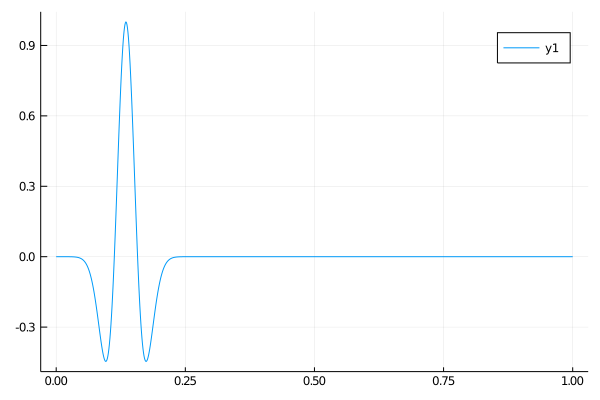

In [4]:
t=config["t"]
N=length(t)
println(N)
w = ricker(t, 10.0)
print(length(w))
plot(t,w)

In [5]:
function point_source(value, position, config)
    nx = length(config["x"])
    dx = config["dx"]
    xbgn = config["x"][1]
    xend = config["x"][nx]
    f = zeros(nx, 1)
    # Find the first spatial sample point beyond the source location
    xpos = position - xbgn
    ixs = convert(Int, max(1, ceil( xpos/dx )))+1
    # Distribute the unit amplitude proportionally 
    # between the two neighboring sample positions
    frac = (ixs*dx - xpos)/dx
    #print(frac, ", ", ixs, ", ", xpos)
    f[ixs,1] = (1. - frac) * value
    f[ixs-1,1] = frac * value
    f
end

point_source (generic function with 1 method)

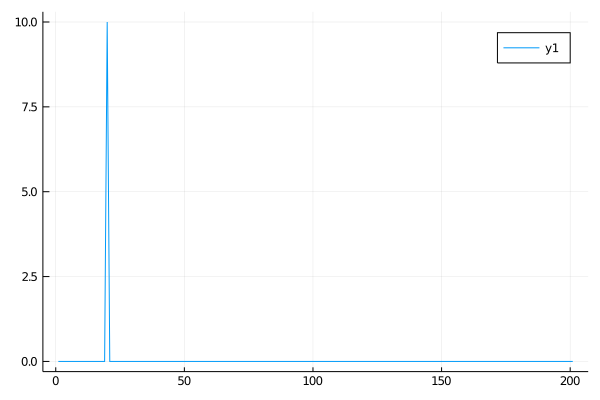

In [6]:
f = point_source(10, 0.1, config)
plot(f)

# Generate the sources
Calculate f(x,t) based on the source position(s)

In [7]:
# Generate the sources
f = zeros(length(config["x"]), length(config["t"]))
for it in 1:length(config["t"])
    t = it*config["dt"]
    s = point_source(ricker(config["t"][it], 10.0), config["x_s"], config)
    f[:, it] = s
end

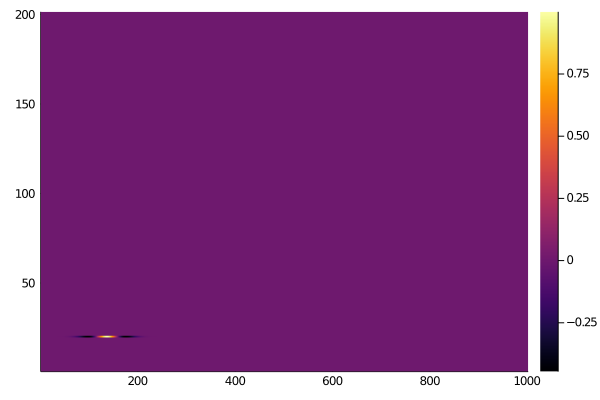

In [8]:
heatmap(f)

# The Forward Wave Equation
## $ (\frac{1}{c(x)^2} \delta_{tt} - \delta_{xx})u(x,t) = f(x,t) $
## $ \delta_{tt} u(x,t) = c(x)^2 * (\delta_{xx} u(x,t) + f(x,t)) $ 
## $ \delta_{tt} u(x,t) = c(x)^2 * ( \frac{U_{i+1} - 2U_i + U_{i-1}}{\Delta x^2} + f(x,t)) $
## $ \delta_{tt} u(x,t) = c(x)^2 * (AU + f(x,t)) $
## $ \delta_t u(x,t) = v $
## $ \delta_t v(x,t) = c(x)^2 * (AU + f(x,t)) $

In [20]:
N = length(config["x"])
A = zeros(N,N)
for i in 1:N, j in 1:N
  abs(i-j)<=1 && (A[i,j]+=1)
  i==j && (A[i,j]-=3)
end
A = A/(config["dx"]^2)

201×201 Array{Float64,2}:
 -80000.0   40000.0       0.0       0.0  …       0.0       0.0       0.0
  40000.0  -80000.0   40000.0       0.0          0.0       0.0       0.0
      0.0   40000.0  -80000.0   40000.0          0.0       0.0       0.0
      0.0       0.0   40000.0  -80000.0          0.0       0.0       0.0
      0.0       0.0       0.0   40000.0          0.0       0.0       0.0
      0.0       0.0       0.0       0.0  …       0.0       0.0       0.0
      0.0       0.0       0.0       0.0          0.0       0.0       0.0
      0.0       0.0       0.0       0.0          0.0       0.0       0.0
      0.0       0.0       0.0       0.0          0.0       0.0       0.0
      0.0       0.0       0.0       0.0          0.0       0.0       0.0
      0.0       0.0       0.0       0.0  …       0.0       0.0       0.0
      0.0       0.0       0.0       0.0          0.0       0.0       0.0
      0.0       0.0       0.0       0.0          0.0       0.0       0.0
      ⋮                  

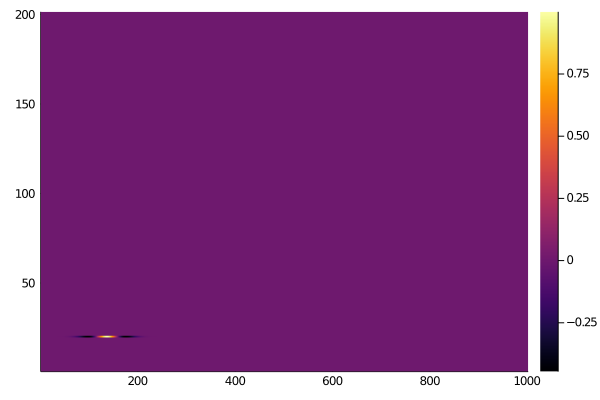

In [21]:
u0=zeros(length(config["x"]), length(config["t"]))
heatmap(A*u0+f)

# Create a basic model for testing
- Gaussian model

In [11]:
function basic_model(config)
    x = config["x"]
    nx = length(x)
    dx = config["dx"]

    xs =  x

    C0 = ones(nx)

    dC = -100.0 .* (xs .- 0.5) .* exp.(-((xs.-0.5).^2)/(1e-4))

    C = C0 + dC

    C, C0
end

basic_model (generic function with 1 method)

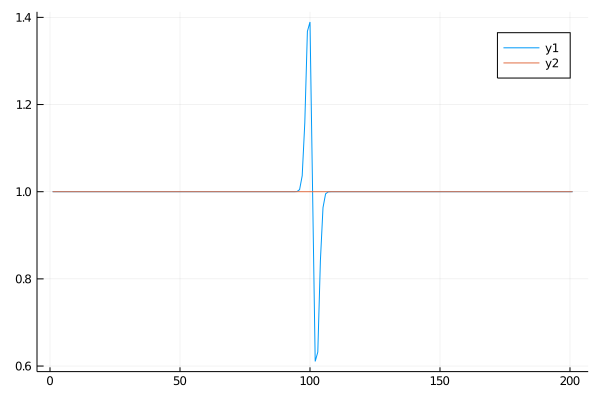

In [12]:
m, m0 = basic_model(config)
plot(m)
plot!(m0)

# Compute the first-order differential equation using ODE

In [32]:
function F(u,p,t)
    A, m = p
    m .^2 .* (A*u + point_source(ricker(t, 10.0), 0.1, config))
end

u0=zeros(length(config["x"]), 1)

tspan = (0.0,1.0)
p = (A, m)
prob = ODEProblem(F, u0, tspan, p, saveat=config["dt"])
sol = solve(prob)

retcode: Success
Interpolation: 1st order linear
t: 1001-element Array{Float64,1}:
 0.0
 0.001
 0.002
 0.003
 0.004
 0.005
 0.006
 0.007
 0.008
 0.009
 0.01
 0.011
 0.012
 ⋮
 0.989
 0.99
 0.991
 0.992
 0.993
 0.994
 0.995
 0.996
 0.997
 0.998
 0.999
 1.0
u: 1001-element Array{Array{Float64,2},1}:
 [0.0; 0.0; … ; 0.0; 0.0]
 [-5.71009956111136e-13; -3.050433833078683e-13; … ; 1.546827501255291e-45; 6.8860784683853064e-46]
 [-1.7969611511994994e-12; -3.615545942459883e-12; … ; -4.639696317002011e-34; -2.193773934915665e-34]
 [-3.5529042710156176e-12; -7.156252623062546e-12; … ; 3.6025453865907513e-25; 1.7696170812492435e-25]
 [-5.566253014725891e-12; -1.118715831225662e-11; … ; -3.32240023570612e-24; -1.630609265459064e-24]
 [-7.490749435164795e-12; -1.503871301255832e-11; … ; 2.279572648037042e-19; 1.1324326190378838e-19]
 [-1.0122725818390574e-11; -2.0311428228811123e-11; … ; 2.498581799668271e-19; 1.2414671015727339e-19]
 [-1.3565659394410608e-11; -2.721204718233823e-11; … ; 4.74666266

(201, 1, 1001)

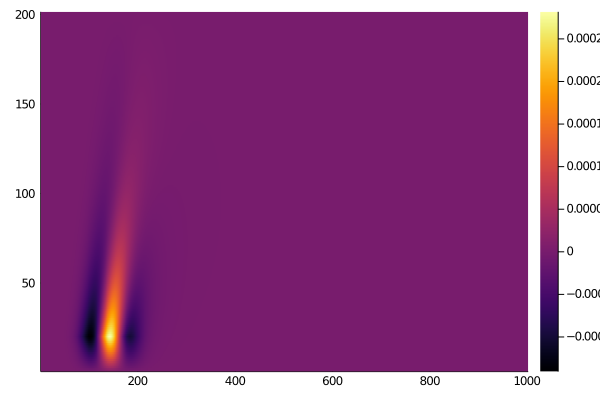

In [33]:
res = Array(sol)
print(size(res))
#res = reshape(res,size(res)[1],size(res)[3])
heatmap(res[:,1,:])

# Compute the second order differential equation using ODE

In [29]:
function FF(du,u,p,t)
    A, m = p
    du = m.^2 .* (A*u + point_source(ricker(t, 10.0), 0.1, config))
end

u0=zeros(length(config["x"]), 1)
#du0=zeros(length(config["x"]), 1)
du0=res[:,1,1:1]
#print(du0)
tspan = (0.0,1.0)
p = [A, m]
prob2 = SecondOrderODEProblem(FF, du0, u0, tspan, p, saveat=config["dt"])
sol2 = solve(prob2)

retcode: Success
Interpolation: 1st order linear
t: 1001-element Array{Float64,1}:
 0.0
 0.001
 0.002
 0.003
 0.004
 0.005
 0.006
 0.007
 0.008
 0.009
 0.01
 0.011
 0.012
 ⋮
 0.989
 0.99
 0.991
 0.992
 0.993
 0.994
 0.995
 0.996
 0.997
 0.998
 0.999
 1.0
u: 1001-element Array{ArrayPartition{Float64,Tuple{Array{Float64,2},Array{Float64,2}}},1}:
 [0.0; 0.0; … ; 0.0; 0.0][0.0; 0.0; … ; 0.0; 0.0]
 [0.0; 0.0; … ; 0.0; 0.0][0.0; 0.0; … ; 0.0; 0.0]
 [0.0; 0.0; … ; 0.0; 0.0][0.0; 0.0; … ; 0.0; 0.0]
 [0.0; 0.0; … ; 0.0; 0.0][0.0; 0.0; … ; 0.0; 0.0]
 [0.0; 0.0; … ; 0.0; 0.0][0.0; 0.0; … ; 0.0; 0.0]
 [0.0; 0.0; … ; 0.0; 0.0][0.0; 0.0; … ; 0.0; 0.0]
 [0.0; 0.0; … ; 0.0; 0.0][0.0; 0.0; … ; 0.0; 0.0]
 [0.0; 0.0; … ; 0.0; 0.0][0.0; 0.0; … ; 0.0; 0.0]
 [0.0; 0.0; … ; 0.0; 0.0][0.0; 0.0; … ; 0.0; 0.0]
 [0.0; 0.0; … ; 0.0; 0.0][0.0; 0.0; … ; 0.0; 0.0]
 [0.0; 0.0; … ; 0.0; 0.0][0.0; 0.0; … ; 0.0; 0.0]
 [0.0; 0.0; … ; 0.0; 0.0][0.0; 0.0; … ; 0.0; 0.0]
 [1.1655633600690719e-49; 2.3992178250366533e-44; … ; 

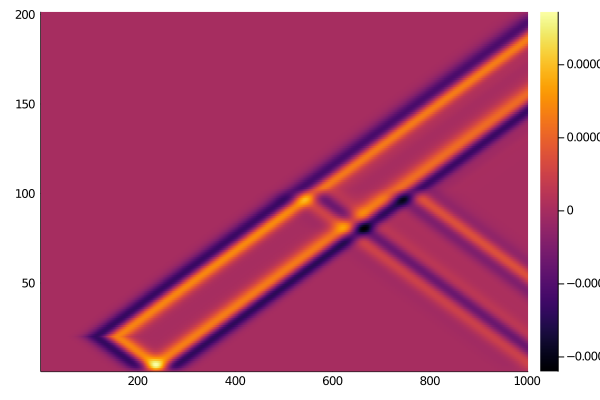

In [36]:
#print(size(sol2))
heatmap(sol2[202:402,:])